In [1]:
import arviz as az
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np
import matplotlib.pyplot as plt
import os
import bambi as bmb

In [2]:
OUTPUT_PATH  = os.getenv("OUTPUT_PATH")
SIPP_MODEL_DATA = "sipp_model.parquet"

In [3]:
sipp_model = pl.read_parquet(os.path.join(OUTPUT_PATH,SIPP_MODEL_DATA))
sipp_model

row_id,state,metro,hh_income,male,age,edu,race_eth,tenure,homevalue,disability,class_worker,household_type,citizen,english_at_home,public_assistance,social_security,poverty,hh_any_asset,hh_any_debt,hh_any_wealth,hh_assets,hh_debts,hh_networth,WPFINWGT,prank_assets,prank_debts,prank_networth
u32,i64,i8,i32,i32,i8,i32,i32,i32,i32,i32,i32,i32,i32,i32,i8,i8,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,f64
0,20,1,5,1,4,1,3,3,1,0,3,4,1,1,0,0,0,0,0,0,null,null,null,5989.598574,null,null,null
1,20,1,8,0,5,3,1,2,4,0,3,4,1,1,0,0,0,1,1,1,102730.0,72400.0,30330.0,3904.848315,0.377196,0.531261,0.348163
2,20,1,12,0,8,1,1,1,4,0,5,1,1,0,0,0,0,1,0,1,125000.0,null,125000.0,3994.372476,0.403515,null,0.523844
3,20,1,10,0,11,2,1,2,3,0,4,2,1,1,0,1,0,1,1,1,156250.0,38000.0,118250.0,4855.915655,0.440057,0.418817,0.51375
4,20,1,12,1,11,5,1,1,4,0,3,2,1,1,0,1,0,1,0,1,3.797801e6,null,3.797801e6,3338.870412,0.971645,null,0.974242
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
26168,6,1,13,1,9,1,3,2,6,0,2,2,1,0,0,0,0,1,1,1,1.444866e6,474000.0,970866.0,3434.59112,0.899592,0.94309,0.870182
26169,6,1,7,1,11,3,4,1,5,1,4,2,1,1,0,1,0,1,0,1,373400.0,null,373400.0,3497.623495,0.638027,null,0.719828
26170,6,1,12,1,7,3,4,2,6,1,3,1,1,0,0,1,0,1,1,1,740350.0,436600.0,303750.0,3369.961703,0.793583,0.93272,0.680865


In [4]:
sipp_model = (sipp_model
 .with_columns(
     pl.concat_str([pl.col("race_eth"),pl.col("state")],separator=":").alias('race_eth_state'),
     pl.concat_str([pl.col("race_eth"),pl.col("edu")],separator=":").alias('race_eth_edu'),
     pl.concat_str([pl.col("race_eth"),pl.col("age")],separator=":").alias('race_eth_age'),
     pl.concat_str([pl.col("race_eth"),pl.col("hh_income")],separator=":").alias('race_eth_income'),
 )
)

# Models

## Any Asset Model

In [5]:
any_asset_model_cols = ['hh_any_asset',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen']

In [6]:
any_asset_model_df = sipp_model.select(pl.col(any_asset_model_cols)).to_pandas().dropna(subset=any_asset_model_cols)
any_asset_model_df

,hh_any_asset,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen
0,0,20,5,4,3,1,3,4,1,1,0,3.0,0,0,0,1
1,1,20,8,5,1,3,2,4,0,1,0,3.0,0,0,0,1
2,1,20,12,8,1,1,1,1,0,1,0,5.0,0,0,0,1
3,1,20,10,11,1,2,2,2,0,1,0,4.0,0,1,0,1
4,1,20,12,11,1,5,1,2,1,1,0,3.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,1,6,3,7,4,3,1,4,0,1,0,2.0,0,0,1,1
26168,1,6,13,9,3,1,2,2,1,1,0,2.0,0,0,0,1
26169,1,6,7,11,4,3,1,2,1,1,1,4.0,0,1,0,1
26170,1,6,12,7,4,3,2,1,1,1,1,3.0,0,1,0,1


In [7]:
any_asset_model_df.describe()

,hh_any_asset,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen
count,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.00000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000
mean,0.968034,27.912778,9.561898,8.348721,1.646172,2.982813,2.10719,2.743192,0.485387,0.828628,0.280389,3.505937,0.069495,0.355986,0.151528,0.940925
std,0.175914,16.261322,4.605019,3.477097,1.053935,1.196355,0.77746,1.181523,0.499797,0.376841,0.449198,0.948001,0.254300,0.478821,0.358570,0.235770
min,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.000000,6.000000,6.000000,1.000000,2.000000,1.00000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,28.000000,9.000000,9.000000,1.000000,3.000000,2.00000,3.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,42.000000,13.000000,11.000000,2.000000,4.000000,3.00000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,56.000000,18.000000,15.000000,5.000000,5.000000,3.00000,4.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
for col in ['state','hh_income','age','race_eth','edu','tenure','household_type','class_worker']:
    any_asset_model_df[col] = any_asset_model_df[col].astype('category')

In [9]:
any_asset_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24088 entries, 0 to 26172
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   hh_any_asset       24088 non-null  int8    
 1   state              24088 non-null  category
 2   hh_income          24088 non-null  category
 3   age                24088 non-null  category
 4   race_eth           24088 non-null  category
 5   edu                24088 non-null  category
 6   tenure             24088 non-null  category
 7   household_type     24088 non-null  category
 8   male               24088 non-null  int32   
 9   metro              24088 non-null  int8    
 10  disability         24088 non-null  int32   
 11  class_worker       24088 non-null  category
 12  public_assistance  24088 non-null  int8    
 13  social_security    24088 non-null  int8    
 14  poverty            24088 non-null  int8    
 15  citizen            24088 non-null  int32   
dtypes: catego

In [10]:
# change tenure from random effect to fixed effect
any_asset_model_formula = """
hh_any_asset ~ male + metro + disability + class_worker + public_assistance + social_security +
poverty + citizen + tenure + (1|state) + (1|hh_income) + (1|age) + (1 | race_eth) + 
(1 | edu) + (1|household_type)
"""

In [11]:
any_asset_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "group_specific": bmb.Prior(
        "Normal",
        mu=0,
        sigma=bmb.Prior("Exponential", lam=1),
    )
}

In [12]:
any_asset_model = bmb.Model(formula=any_asset_model_formula, 
                            data=any_asset_model_df, 
                            family="bernoulli",
                            priors=any_asset_priors,
                            noncentered=True)

In [13]:
any_asset_model_idata = any_asset_model.fit(draws=1000,
                                            tune=1500,
                                            chains=4,
                                            target_accept=0.98, 
                                            sampler_kwargs={"max_treedepth":15})

Modeling the probability that hh_any_asset==1
Initializing NUTS using jitter+adapt_diag...
c:\Users\nicho\.conda\envs\no-lwp\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, male, metro, disability, class_worker, public_assistance, social_security, poverty, citizen, tenure, 1|state_sigma, 1|state_offset, 1|hh_income_

Output()

Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 1752 seconds.


In [14]:
az.to_netcdf(any_asset_model_idata,r'models/any_asset_model_20260222.nc')

'models/any_asset_model_20260222.nc'

In [25]:
any_asset_model_summ = az.summary(any_asset_model_idata, var_names=["Intercept", "male", "metro", "disability", "poverty","citizen","tenure"], round_to=3)
any_asset_model_summ[["mean","sd","hdi_3%","hdi_97%","r_hat","ess_bulk","ess_tail"]]


,mean,sd,hdi_3%,hdi_97%,r_hat,ess_bulk,ess_tail
Intercept,8.285,0.916,6.585,10.002,1.003,976.314,1396.907
male,0.024,0.093,-0.157,0.186,1.001,4176.579,3110.519
metro,-0.174,0.122,-0.403,0.046,1.002,3984.528,3048.276
disability,-0.210,0.102,-0.406,-0.023,1.001,3715.662,2785.138
poverty,0.008,0.125,-0.224,0.248,1.002,4356.521,3020.672
citizen,0.131,0.155,-0.179,0.406,1.001,3747.658,2918.200
tenure[2],1.040,0.602,-0.052,2.195,1.002,3905.527,2570.342
tenure[3],-3.606,0.319,-4.198,-3.029,1.001,3926.491,3275.236


In [16]:
post_vars = list(any_asset_model_idata.posterior.data_vars)
sd_like = [v for v in post_vars if ("sigma" in v.lower()) or ("sd" in v.lower())]
summ_sd = az.summary(any_asset_model_idata, var_names=sd_like, round_to=3)
summ_sd

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|state_sigma,0.299,0.068,0.180,0.434,0.002,0.001,1508.677,2409.275,1.001
1|hh_income_sigma,1.350,0.274,0.881,1.872,0.009,0.007,974.588,1467.854,1.004
1|age_sigma,0.284,0.090,0.136,0.456,0.003,0.002,1251.658,2165.145,1.002
1|race_eth_sigma,0.677,0.325,0.231,1.230,0.009,0.013,1262.929,1564.096,1.004
1|edu_sigma,0.817,0.412,0.312,1.556,0.015,0.031,1063.842,1265.795,1.001
1|household_type_sigma,0.512,0.334,0.105,1.110,0.009,0.012,1300.799,2389.541,1.001


In [17]:
any_asset_model_df.groupby("tenure",observed=False)["hh_any_asset"].mean()

tenure
1    0.999021
2    0.999892
3    0.912389
Name: hh_any_asset, dtype: float64

In [18]:
any_asset_model_df.groupby("tenure",observed=False)["hh_any_asset"].count()

tenure
1    6127
2    9252
3    8709
Name: hh_any_asset, dtype: int64

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'male'}>,
        <Axes: title={'center': 'male'}>],
       [<Axes: title={'center': 'metro'}>,
        <Axes: title={'center': 'metro'}>],
       [<Axes: title={'center': '1|hh_income_sigma'}>,
        <Axes: title={'center': '1|hh_income_sigma'}>]], dtype=object)

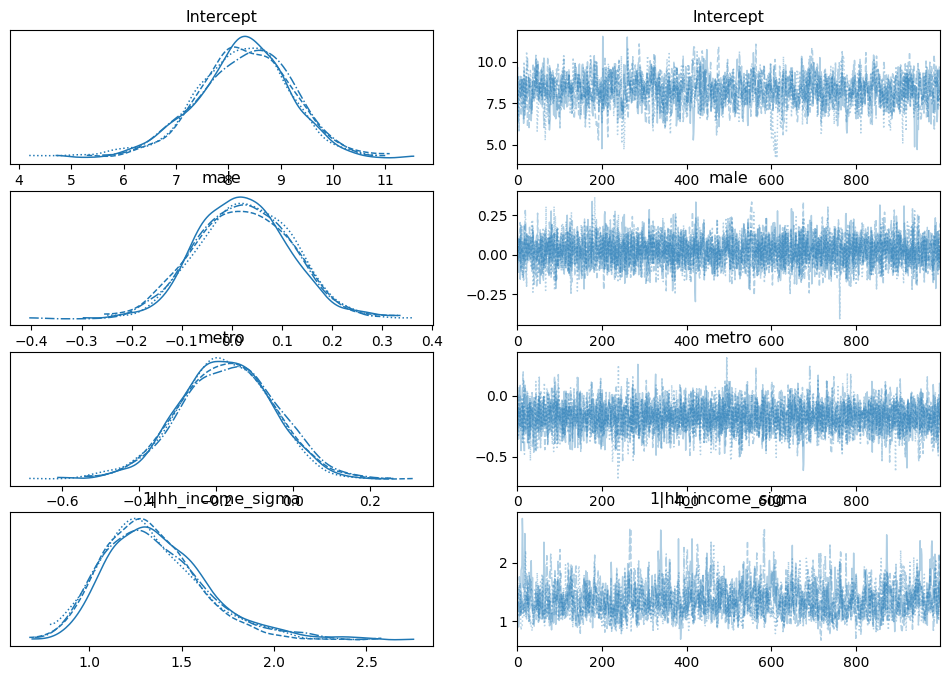

In [19]:
az.plot_trace(
    any_asset_model_idata,
    var_names=["Intercept", "male", "metro", "1|hh_income_sigma"],
)

array([<Axes: title={'center': 'metro'}>,
       <Axes: title={'center': 'male'}>,
       <Axes: title={'center': 'citizen'}>], dtype=object)

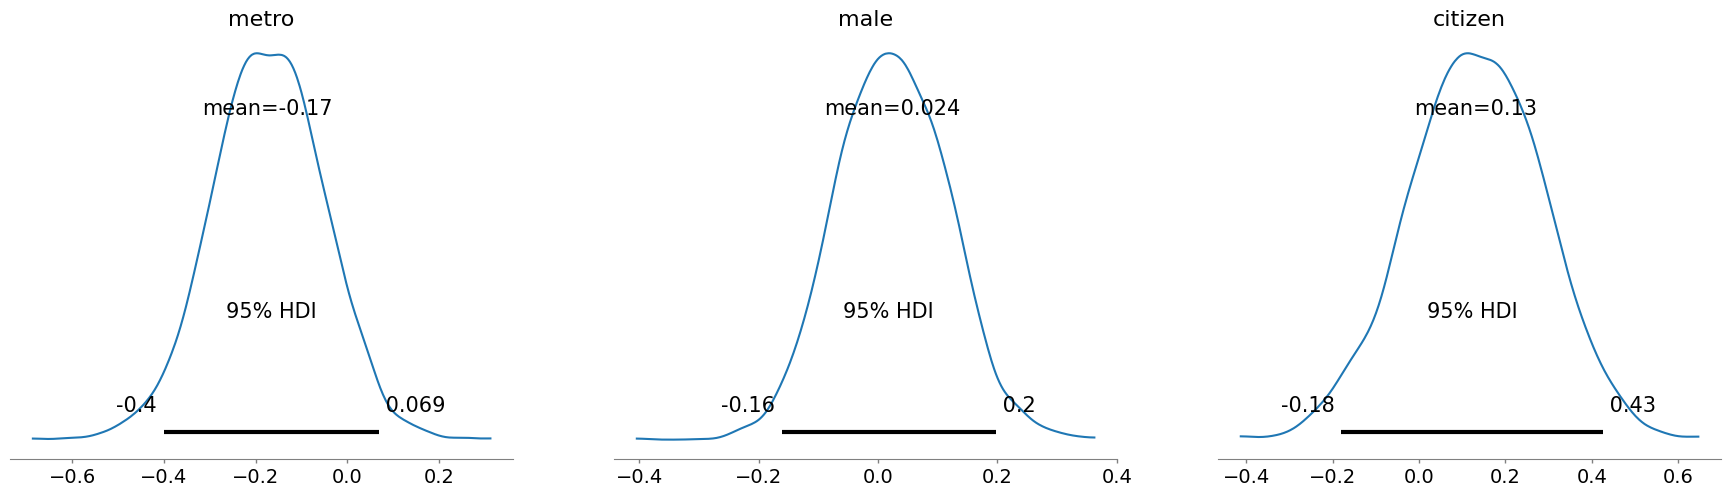

In [20]:
az.plot_posterior(
    any_asset_model_idata,
    var_names=["metro", "male", "citizen"],
    hdi_prob=0.95
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

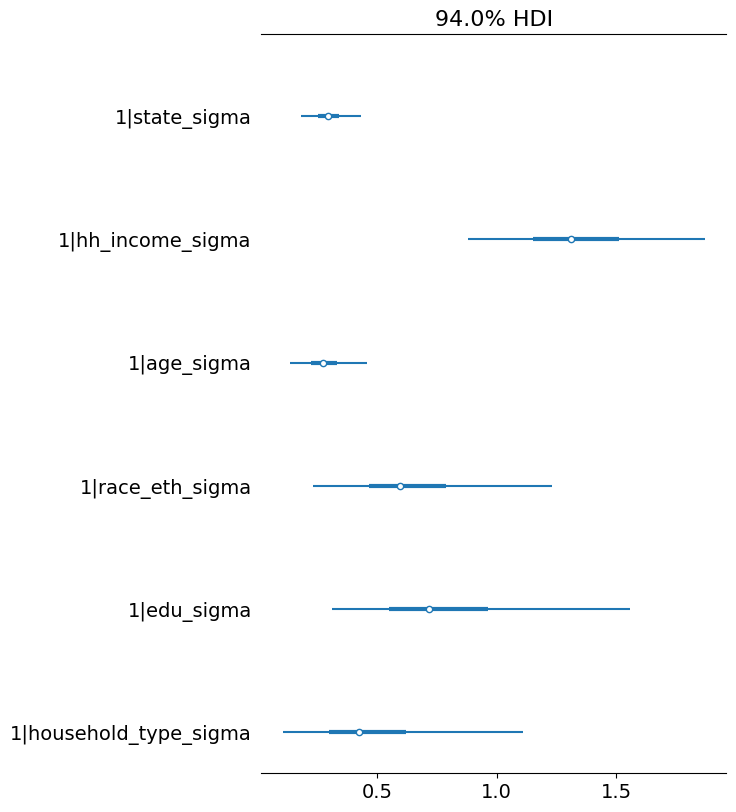

In [87]:
az.plot_forest(
    any_asset_model_idata,
    var_names=["1|state_sigma",
               "1|hh_income_sigma",
               "1|age_sigma",
               "1|race_eth_sigma",
               "1|edu_sigma",
               "1|household_type_sigma"],
    combined=True,
)


## Any Debt Model

In [22]:
any_debt_model_cols = ['hh_any_debt',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen']

In [23]:
any_debt_model_df = sipp_model.select(pl.col(any_debt_model_cols)).to_pandas().dropna(subset=any_debt_model_cols)
any_debt_model_df

,hh_any_debt,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen
0,0,20,5,4,3,1,3,4,1,1,0,3.0,0,0,0,1
1,1,20,8,5,1,3,2,4,0,1,0,3.0,0,0,0,1
2,0,20,12,8,1,1,1,1,0,1,0,5.0,0,0,0,1
3,1,20,10,11,1,2,2,2,0,1,0,4.0,0,1,0,1
4,0,20,12,11,1,5,1,2,1,1,0,3.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,1,6,3,7,4,3,1,4,0,1,0,2.0,0,0,1,1
26168,1,6,13,9,3,1,2,2,1,1,0,2.0,0,0,0,1
26169,0,6,7,11,4,3,1,2,1,1,1,4.0,0,1,0,1
26170,1,6,12,7,4,3,2,1,1,1,1,3.0,0,1,0,1


In [24]:
any_debt_model_df.describe()

,hh_any_debt,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen
count,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.00000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000,24088.000000
mean,0.740991,27.912778,9.561898,8.348721,1.646172,2.982813,2.10719,2.743192,0.485387,0.828628,0.280389,3.505937,0.069495,0.355986,0.151528,0.940925
std,0.438099,16.261322,4.605019,3.477097,1.053935,1.196355,0.77746,1.181523,0.499797,0.376841,0.449198,0.948001,0.254300,0.478821,0.358570,0.235770
min,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,6.000000,6.000000,1.000000,2.000000,1.00000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,28.000000,9.000000,9.000000,1.000000,3.000000,2.00000,3.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,42.000000,13.000000,11.000000,2.000000,4.000000,3.00000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,56.000000,18.000000,15.000000,5.000000,5.000000,3.00000,4.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
for col in ['state','hh_income','age','race_eth','edu','tenure','household_type','class_worker']:
    any_debt_model_df[col] = any_debt_model_df[col].astype('category')

In [27]:
any_debt_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24088 entries, 0 to 26172
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   hh_any_debt        24088 non-null  int8    
 1   state              24088 non-null  category
 2   hh_income          24088 non-null  category
 3   age                24088 non-null  category
 4   race_eth           24088 non-null  category
 5   edu                24088 non-null  category
 6   tenure             24088 non-null  category
 7   household_type     24088 non-null  category
 8   male               24088 non-null  int32   
 9   metro              24088 non-null  int8    
 10  disability         24088 non-null  int32   
 11  class_worker       24088 non-null  category
 12  public_assistance  24088 non-null  int8    
 13  social_security    24088 non-null  int8    
 14  poverty            24088 non-null  int8    
 15  citizen            24088 non-null  int32   
dtypes: catego

In [28]:
# change tenure from random effect to fixed effect
any_debt_model_formula = """
hh_any_debt ~ male + metro + disability + class_worker + public_assistance + social_security +
poverty + citizen + tenure + (1|state) + (1|hh_income) + (1|age) + (1 | race_eth) + 
(1 | edu) + (1|household_type)
"""

In [29]:
any_debt_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "group_specific": bmb.Prior(
        "Normal",
        mu=0,
        sigma=bmb.Prior("Exponential", lam=1),
    )
}

In [30]:
any_debt_model = bmb.Model(formula=any_debt_model_formula, 
                            data=any_debt_model_df, 
                            family="bernoulli",
                            priors=any_debt_priors,
                            noncentered=True)

In [31]:
any_debt_model_idata = any_debt_model.fit(draws=1000,
                                            tune=1500,
                                            chains=4,
                                            target_accept=0.98, 
                                            sampler_kwargs={"max_treedepth":15})

Modeling the probability that hh_any_debt==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, male, metro, disability, class_worker, public_assistance, social_security, poverty, citizen, tenure, 1|state_sigma, 1|state_offset, 1|hh_income_sigma, 1|hh_income_offset, 1|age_sigma, 1|age_offset, 1|race_eth_sigma, 1|race_eth_offset, 1|edu_sigma, 1|edu_offset, 1|household_type_sigma, 1|household_type_offset]


Output()

Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 1637 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [32]:
az.to_netcdf(any_debt_model_idata,r'models/any_debt_model_20260222.nc')

'models/any_debt_model_20260222.nc'

In [33]:
any_debt_model_summ = az.summary(any_debt_model_idata, var_names=["Intercept", "male", "metro", "disability", "poverty","citizen","tenure"], round_to=3)
any_debt_model_summ[["mean","sd","hdi_3%","hdi_97%","r_hat","ess_bulk","ess_tail"]]


,mean,sd,hdi_3%,hdi_97%,r_hat,ess_bulk,ess_tail
Intercept,0.252,0.360,-0.400,0.953,1.001,860.175,1267.912
male,-0.211,0.037,-0.277,-0.140,1.001,4205.015,2903.771
metro,-0.072,0.048,-0.162,0.014,1.000,4067.322,3098.317
disability,0.303,0.045,0.219,0.387,1.001,5409.490,3162.690
poverty,-0.323,0.068,-0.453,-0.199,1.001,2819.903,2834.740
citizen,0.683,0.078,0.542,0.835,1.002,4496.506,2987.158
tenure[2],3.834,0.092,3.669,4.011,1.001,3833.131,2599.194
tenure[3],0.409,0.046,0.320,0.487,1.000,3335.240,3060.824


In [34]:
post_vars = list(any_debt_model_idata.posterior.data_vars)
sd_like = [v for v in post_vars if ("sigma" in v.lower()) or ("sd" in v.lower())]
summ_sd = az.summary(any_debt_model_idata, var_names=sd_like, round_to=3)
summ_sd

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|state_sigma,0.117,0.028,0.064,0.168,0.001,0.000,1261.182,1766.161,1.002
1|hh_income_sigma,0.348,0.074,0.230,0.492,0.003,0.002,691.712,996.964,1.004
1|age_sigma,0.630,0.143,0.394,0.896,0.005,0.004,794.406,1432.695,1.005
1|race_eth_sigma,0.233,0.144,0.063,0.462,0.004,0.008,1499.714,2128.852,1.001
1|edu_sigma,0.248,0.135,0.086,0.481,0.003,0.005,1392.234,2079.864,1.002
1|household_type_sigma,0.305,0.209,0.082,0.659,0.006,0.011,1475.336,1525.846,1.001


In [35]:
any_debt_model_df.groupby("tenure",observed=False)["hh_any_debt"].mean()

tenure
1    0.513628
2    0.986489
3    0.640142
Name: hh_any_debt, dtype: float64

In [36]:
any_debt_model_df.groupby("tenure",observed=False)["hh_any_debt"].count()

tenure
1    6127
2    9252
3    8709
Name: hh_any_debt, dtype: int64

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'male'}>,
        <Axes: title={'center': 'male'}>],
       [<Axes: title={'center': 'metro'}>,
        <Axes: title={'center': 'metro'}>],
       [<Axes: title={'center': '1|hh_income_sigma'}>,
        <Axes: title={'center': '1|hh_income_sigma'}>]], dtype=object)

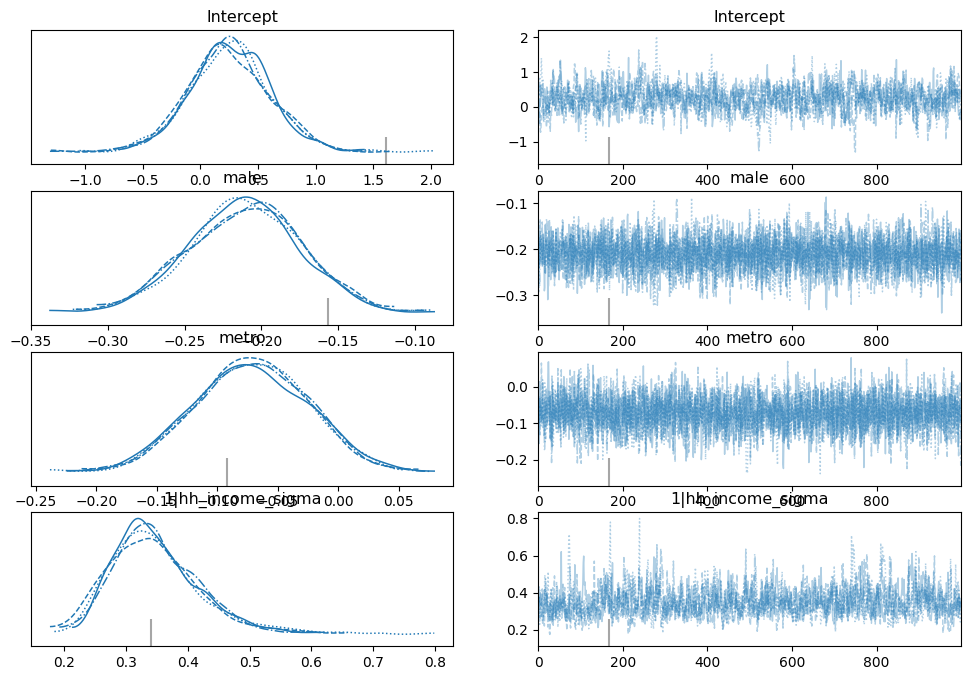

In [37]:
az.plot_trace(
    any_debt_model_idata,
    var_names=["Intercept", "male", "metro", "1|hh_income_sigma"],
)

array([<Axes: title={'center': 'metro'}>,
       <Axes: title={'center': 'male'}>,
       <Axes: title={'center': 'citizen'}>], dtype=object)

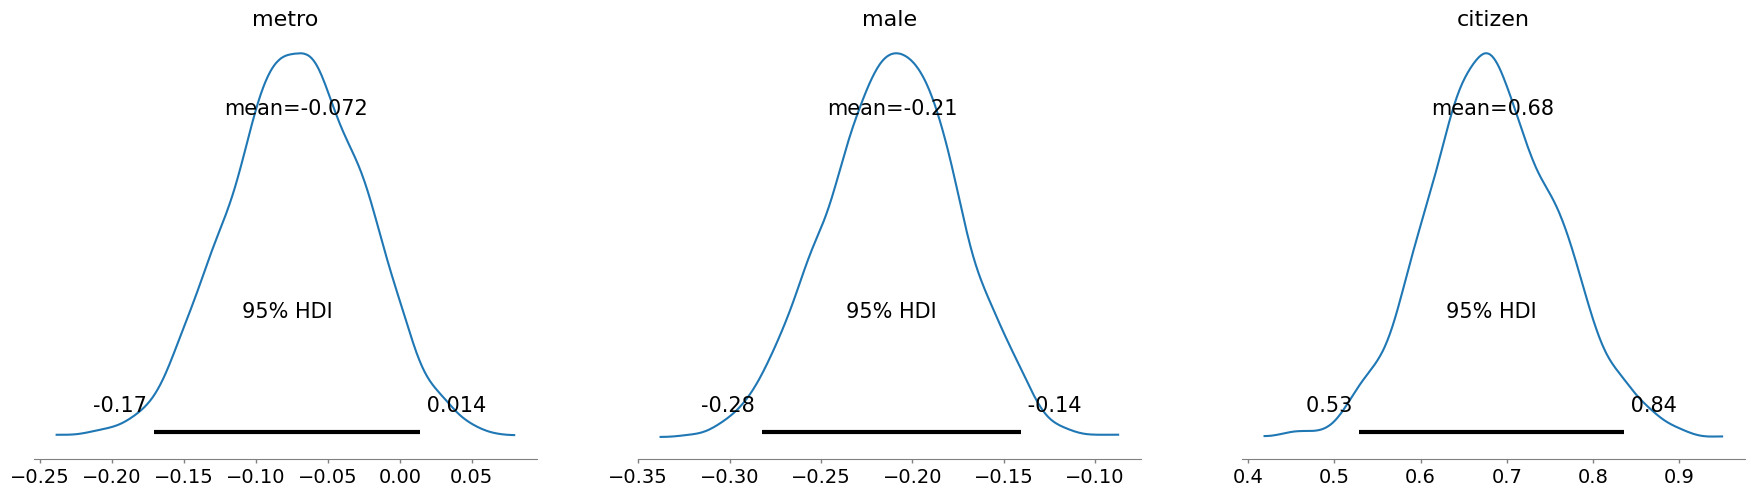

In [38]:
az.plot_posterior(
    any_debt_model_idata,
    var_names=["metro", "male", "citizen"],
    hdi_prob=0.95
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

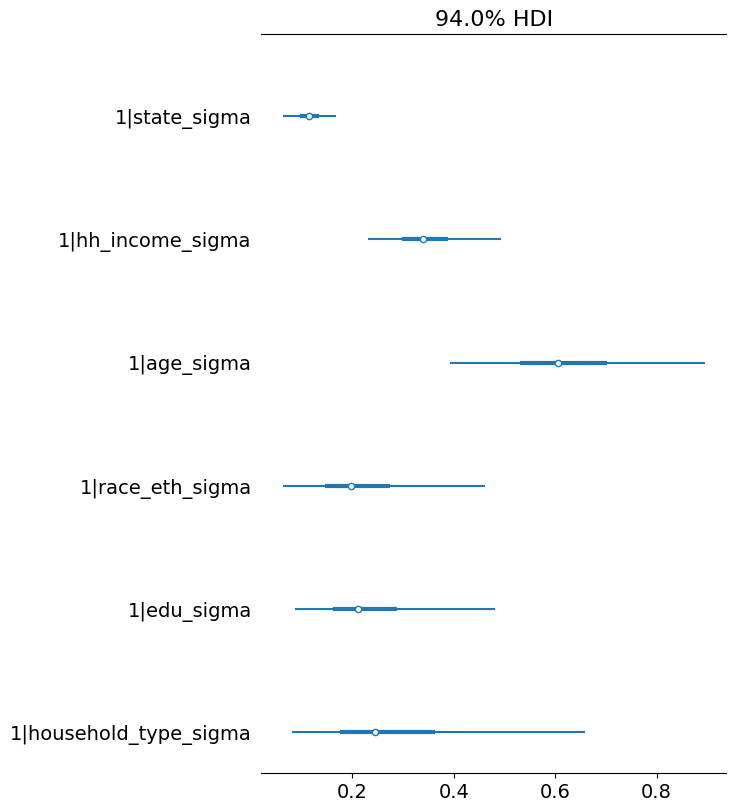

In [39]:
az.plot_forest(
    any_debt_model_idata,
    var_names=["1|state_sigma",
               "1|hh_income_sigma",
               "1|age_sigma",
               "1|race_eth_sigma",
               "1|edu_sigma",
               "1|household_type_sigma"],
    combined=True,
)


## Percent Rank Asset Model

In [64]:
pr_asset_model_cols = ['prank_assets',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen',
'english_at_home',
'homevalue',
'race_eth_state',	
'race_eth_edu',	
'race_eth_age',	
'race_eth_income']

In [65]:
pr_asset_model_df = sipp_model.select(pl.col(pr_asset_model_cols)).to_pandas().dropna(subset=pr_asset_model_cols)
pr_asset_model_df

,prank_assets,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,...,public_assistance,social_security,poverty,citizen,english_at_home,homevalue,race_eth_state,race_eth_edu,race_eth_age,race_eth_income
1,0.377196,20,8,5,1,3,2,4,0,1,...,0,0,0,1,1,4,1:20,1:3,1:5,1:8
2,0.403515,20,12,8,1,1,1,1,0,1,...,0,0,0,1,0,4,1:20,1:1,1:8,1:12
3,0.440057,20,10,11,1,2,2,2,0,1,...,0,1,0,1,1,3,1:20,1:2,1:11,1:10
4,0.971645,20,12,11,1,5,1,2,1,1,...,0,1,0,1,1,4,1:20,1:5,1:11,1:12
6,0.246809,20,4,2,4,4,3,4,1,1,...,0,0,0,1,1,1,4:20,4:4,4:2,4:4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,0.817834,6,3,7,4,3,1,4,0,1,...,0,0,1,1,1,6,4:6,4:3,4:7,4:3
26168,0.899592,6,13,9,3,1,2,2,1,1,...,0,0,0,1,0,6,3:6,3:1,3:9,3:13
26169,0.638027,6,7,11,4,3,1,2,1,1,...,0,1,0,1,1,5,4:6,4:3,4:11,4:7
26170,0.793583,6,12,7,4,3,2,1,1,1,...,0,1,0,1,0,6,4:6,4:3,4:7,4:12


In [67]:
pr_asset_model_df.describe()

,prank_assets,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen,english_at_home,homevalue
count,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000,23318.000000
mean,0.498103,27.934857,9.752466,8.376962,1.630200,3.015139,2.078266,2.719316,0.490008,0.828030,0.273523,3.481516,0.061069,0.358607,0.135775,0.942405,0.882537,3.133373
std,0.285088,16.289952,4.535948,3.473007,1.051984,1.190224,0.772766,1.184124,0.499911,0.377363,0.445776,0.940562,0.239461,0.479602,0.342557,0.232981,0.321978,1.852650
min,0.000025,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.256953,12.000000,6.000000,6.000000,1.000000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.495600,28.000000,10.000000,9.000000,1.000000,3.000000,2.000000,3.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000
75%,0.741232,42.000000,13.000000,11.000000,2.000000,4.000000,3.000000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,4.000000
max,0.999942,56.000000,18.000000,15.000000,5.000000,5.000000,3.000000,4.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


In [68]:
for col in ['state','hh_income','age','race_eth','edu','tenure',
            'household_type','class_worker','homevalue','race_eth_state',
            'race_eth_edu',	'race_eth_age',	'race_eth_income']:
    pr_asset_model_df[col] = pr_asset_model_df[col].astype('category')

In [69]:
pr_asset_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23318 entries, 1 to 26172
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   prank_assets       23318 non-null  float64 
 1   state              23318 non-null  category
 2   hh_income          23318 non-null  category
 3   age                23318 non-null  category
 4   race_eth           23318 non-null  category
 5   edu                23318 non-null  category
 6   tenure             23318 non-null  category
 7   household_type     23318 non-null  category
 8   male               23318 non-null  int32   
 9   metro              23318 non-null  int8    
 10  disability         23318 non-null  int32   
 11  class_worker       23318 non-null  category
 12  public_assistance  23318 non-null  int8    
 13  social_security    23318 non-null  int8    
 14  poverty            23318 non-null  int8    
 15  citizen            23318 non-null  int32   
 16  english_a

In [70]:
# change tenure from random effect to fixed effect
pr_asset_model_formula = """
prank_assets ~ male + metro + disability + class_worker + public_assistance
            + social_security + poverty + citizen + english_at_home + homevalue
            + tenure
            + (1|state) + (1|hh_income) + (1|age) + (1|race_eth) + (1|edu)
            + (1|household_type)
            + (1|race_eth:state) + (1|race_eth:edu) + (1|race_eth:age) + (1|race_eth:hh_income)
"""

In [71]:
pr_asset_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "group_specific": bmb.Prior(
        "Normal",
        mu=0,
        sigma=bmb.Prior("Exponential", lam=1),
    )
}

In [72]:
pr_asset_model = bmb.Model(formula=pr_asset_model_formula, 
                            data=pr_asset_model_df, 
                            family="beta",
                            link='logit',
                            priors=pr_asset_priors,
                            noncentered=True)

In [73]:
pr_asset_model_idata = pr_asset_model.fit(draws=2500,
                                          tune=2500,
                                          chains=4,
                                          target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept, male, metro, disability, class_worker, public_assistance, social_security, poverty, citizen, english_at_home, homevalue, tenure, 1|state_sigma, 1|state_offset, 1|hh_income_sigma, 1|hh_income_offset, 1|age_sigma, 1|age_offset, 1|race_eth_sigma, 1|race_eth_offset, 1|edu_sigma, 1|edu_offset, 1|household_type_sigma, 1|household_type_offset, 1|race_eth:state_sigma, 1|race_eth:state_offset, 1|race_eth:edu_sigma, 1|race_eth:edu_offset, 1|race_eth:age_sigma, 1|race_eth:age_offset, 1|race_eth:hh_income_sigma, 1|race_eth:hh_income_offset]


Output()

Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 21007 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [74]:
az.to_netcdf(pr_asset_model_idata,r'models/pr_asset_model_20260222.nc')

'models/pr_asset_model_20260222.nc'

In [80]:
pr_asset_model_summ = az.summary(pr_asset_model_idata, var_names=["Intercept", "male", "metro","disability",'class_worker','public_assistance',
                                                                  'social_security',"poverty","citizen",'english_at_home','homevalue',
                                                                  'tenure'], round_to=3)
pr_asset_model_summ[["mean","sd","hdi_3%","hdi_97%","r_hat","ess_bulk","ess_tail"]]


,mean,sd,hdi_3%,hdi_97%,r_hat,ess_bulk,ess_tail
Intercept,1.016,0.442,0.160,1.825,1.005,915.652,1875.011
male,0.036,0.010,0.018,0.054,1.000,14024.002,6921.994
metro,0.011,0.013,-0.013,0.037,1.000,12097.430,8052.759
disability,-0.129,0.012,-0.151,-0.107,1.000,13479.356,7682.340
class_worker[2.0],-0.236,0.036,-0.302,-0.167,1.001,3647.071,5930.091
class_worker[3.0],-0.569,0.030,-0.625,-0.511,1.001,3146.427,5129.720
class_worker[4.0],-0.382,0.036,-0.448,-0.315,1.000,3565.471,6300.844
class_worker[5.0],-0.490,0.032,-0.551,-0.429,1.000,3044.844,5110.844
public_assistance,-0.281,0.021,-0.319,-0.238,1.000,11850.707,7341.085
social_security,-0.051,0.016,-0.081,-0.021,1.001,10683.789,7470.159


In [81]:
post_vars = list(pr_asset_model_idata.posterior.data_vars)
sd_like = [v for v in post_vars if ("sigma" in v.lower()) or ("sd" in v.lower())]
summ_sd = az.summary(pr_asset_model_idata, var_names=sd_like, round_to=3)
summ_sd

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|state_sigma,0.036,0.014,0.004,0.060,0.001,0.000,653.768,731.012,1.003
1|hh_income_sigma,0.527,0.097,0.353,0.698,0.003,0.002,1301.285,2516.698,1.003
1|age_sigma,0.164,0.041,0.095,0.238,0.001,0.001,2441.364,4288.018,1.001
1|race_eth_sigma,0.147,0.091,0.044,0.294,0.002,0.004,3315.631,5620.229,1.003
1|edu_sigma,0.279,0.161,0.095,0.526,0.003,0.008,2846.557,4278.077,1.001
1|household_type_sigma,0.131,0.110,0.032,0.287,0.002,0.005,3330.472,4434.009,1.003
1|race_eth:state_sigma,0.054,0.012,0.032,0.077,0.000,0.000,990.696,2050.349,1.004
1|race_eth:edu_sigma,0.033,0.014,0.007,0.060,0.000,0.000,2866.654,2684.629,1.002
1|race_eth:age_sigma,0.063,0.011,0.043,0.084,0.000,0.000,3696.295,6248.519,1.000
1|race_eth:hh_income_sigma,0.013,0.009,0.000,0.030,0.000,0.000,3023.980,3396.831,1.001


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'male'}>,
        <Axes: title={'center': 'male'}>],
       [<Axes: title={'center': 'metro'}>,
        <Axes: title={'center': 'metro'}>],
       [<Axes: title={'center': '1|hh_income_sigma'}>,
        <Axes: title={'center': '1|hh_income_sigma'}>]], dtype=object)

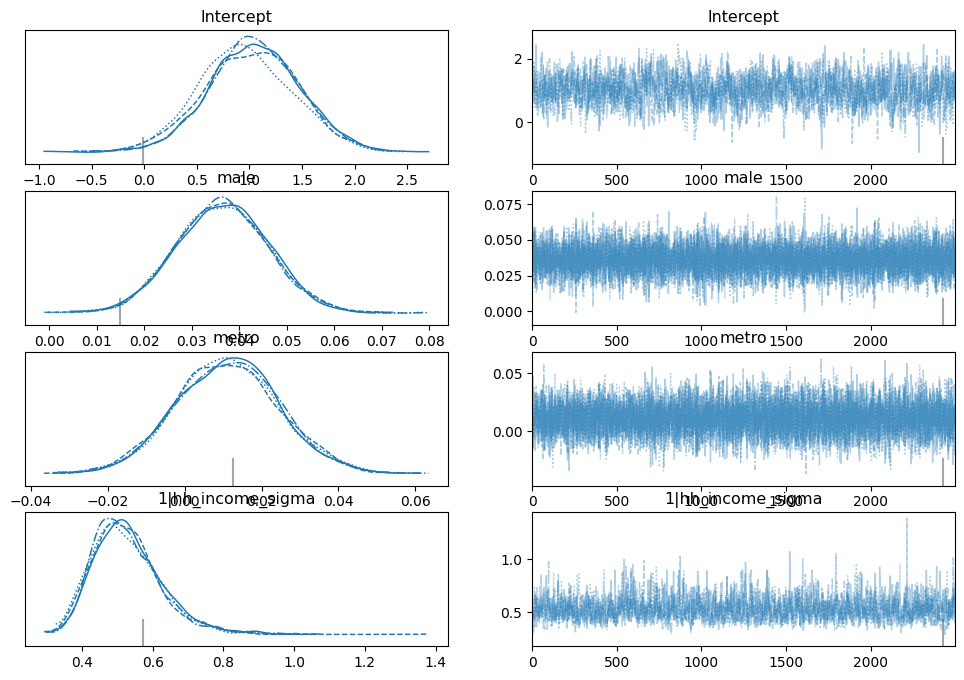

In [82]:
az.plot_trace(
    pr_asset_model_idata,
    var_names=["Intercept", "male", "metro", "1|hh_income_sigma"],
)

array([<Axes: title={'center': 'metro'}>,
       <Axes: title={'center': 'male'}>,
       <Axes: title={'center': 'citizen'}>], dtype=object)

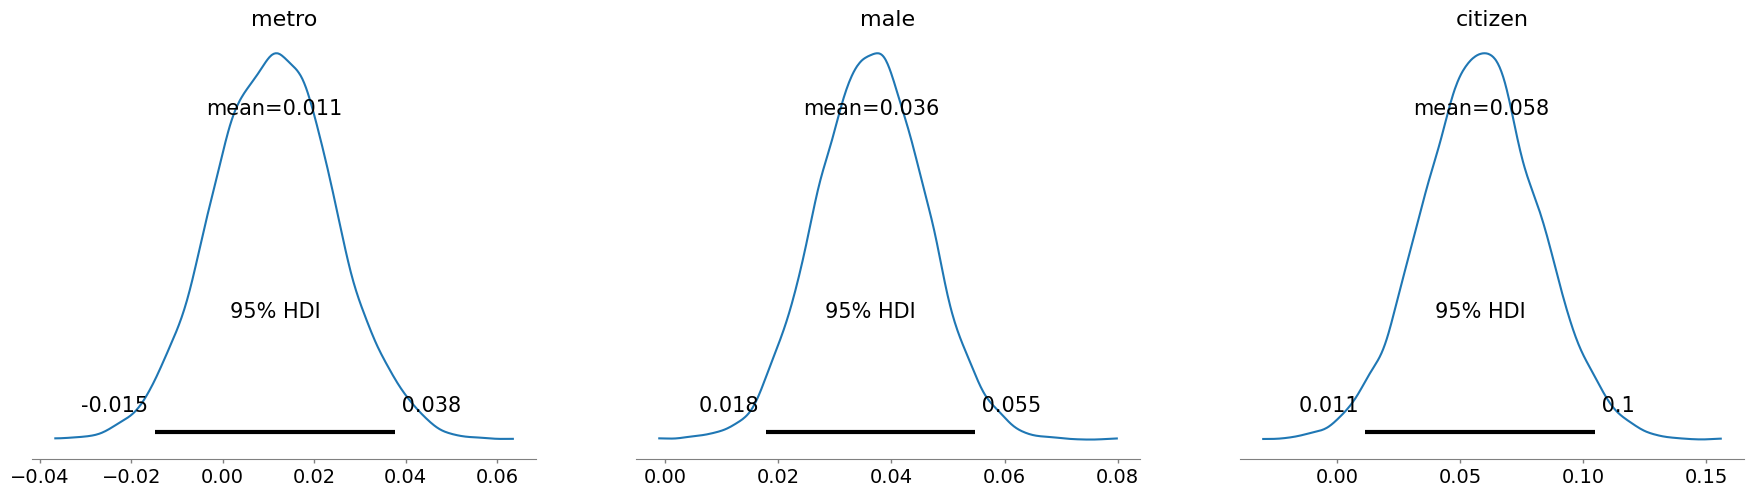

In [83]:
az.plot_posterior(
    pr_asset_model_idata,
    var_names=["metro", "male", "citizen"],
    hdi_prob=0.95
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

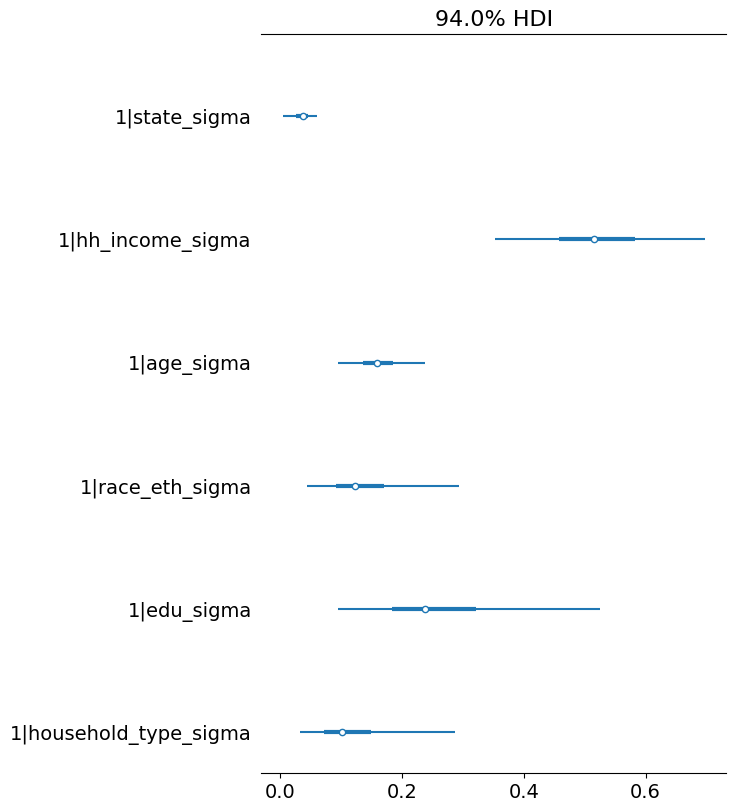

In [84]:
az.plot_forest(
    pr_asset_model_idata,
    var_names=["1|state_sigma",
               "1|hh_income_sigma",
               "1|age_sigma",
               "1|race_eth_sigma",
               "1|edu_sigma",
               "1|household_type_sigma"],
    combined=True,
)


## Percent Rank Debt Model

In [40]:
pr_debt_model_cols = ['prank_debts',
'state',
'hh_income',
'age',
'race_eth',
'edu',
'tenure',
'household_type',
'male',
'metro',
'disability',
'class_worker',
'public_assistance',
'social_security',
'poverty',
'citizen',
'english_at_home',
'homevalue',
'race_eth_state',	
'race_eth_edu',	
'race_eth_age',	
'race_eth_income']

In [41]:
pr_debt_model_df = sipp_model.select(pl.col(pr_debt_model_cols)).to_pandas().dropna(subset=pr_debt_model_cols)
pr_debt_model_df

,prank_debts,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,...,public_assistance,social_security,poverty,citizen,english_at_home,homevalue,race_eth_state,race_eth_edu,race_eth_age,race_eth_income
1,0.531261,20,8,5,1,3,2,4,0,1,...,0,0,0,1,1,4,1:20,1:3,1:5,1:8
3,0.418817,20,10,11,1,2,2,2,0,1,...,0,1,0,1,1,3,1:20,1:2,1:11,1:10
6,0.458034,20,4,2,4,4,3,4,1,1,...,0,0,0,1,1,1,4:20,4:4,4:2,4:4
7,0.241768,20,8,3,3,4,3,2,1,1,...,0,0,0,0,0,1,3:20,3:4,3:3,3:8
8,0.253933,20,6,9,1,4,3,2,1,1,...,0,0,0,1,1,1,1:20,1:4,1:9,1:6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26166,0.089625,6,13,4,3,5,3,2,1,1,...,0,0,0,1,1,1,3:6,3:5,3:4,3:13
26167,0.471261,6,3,7,4,3,1,4,0,1,...,0,0,1,1,1,6,4:6,4:3,4:7,4:3
26168,0.943090,6,13,9,3,1,2,2,1,1,...,0,0,0,1,0,6,3:6,3:1,3:9,3:13
26170,0.932720,6,12,7,4,3,2,1,1,1,...,0,1,0,1,0,6,4:6,4:3,4:7,4:12


In [43]:
# since using beta family and min value is 0.000000 squish values to avoid any values that are exactly 0 or 1
eps = 1e-6
pr_debt_model_df["prank_debts_adj"] = np.clip(pr_debt_model_df["prank_debts"], eps, 1 - eps)

In [44]:
pr_debt_model_df.describe()

,prank_debts,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,disability,class_worker,public_assistance,social_security,poverty,citizen,english_at_home,homevalue,prank_debts_adj
count,17849.000000,17849.00000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000,17849.000000
mean,0.491044,27.90851,10.337498,7.948120,1.640036,3.075691,2.136030,2.601995,0.490168,0.835677,0.250266,3.407978,0.056586,0.308028,0.112667,0.948849,0.879769,3.239957,0.491044
std,0.286739,16.34965,4.428531,3.205847,1.053006,1.169584,0.685695,1.189200,0.499917,0.370579,0.433178,0.951452,0.231056,0.461691,0.316195,0.220312,0.325240,1.837731,0.286739
min,0.000000,1.00000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000001
25%,0.243390,12.00000,7.000000,5.000000,1.000000,2.000000,2.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.243390
50%,0.488530,27.00000,10.000000,8.000000,1.000000,3.000000,2.000000,2.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,0.488530
75%,0.734606,42.00000,14.000000,10.000000,2.000000,4.000000,3.000000,4.000000,1.000000,1.000000,1.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,4.000000,0.734606
max,0.999936,56.00000,18.000000,15.000000,5.000000,5.000000,3.000000,4.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,0.999936


In [45]:
pr_debt_model_df

,prank_debts,state,hh_income,age,race_eth,edu,tenure,household_type,male,metro,...,social_security,poverty,citizen,english_at_home,homevalue,race_eth_state,race_eth_edu,race_eth_age,race_eth_income,prank_debts_adj
1,0.531261,20,8,5,1,3,2,4,0,1,...,0,0,1,1,4,1:20,1:3,1:5,1:8,0.531261
3,0.418817,20,10,11,1,2,2,2,0,1,...,1,0,1,1,3,1:20,1:2,1:11,1:10,0.418817
6,0.458034,20,4,2,4,4,3,4,1,1,...,0,0,1,1,1,4:20,4:4,4:2,4:4,0.458034
7,0.241768,20,8,3,3,4,3,2,1,1,...,0,0,0,0,1,3:20,3:4,3:3,3:8,0.241768
8,0.253933,20,6,9,1,4,3,2,1,1,...,0,0,1,1,1,1:20,1:4,1:9,1:6,0.253933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26166,0.089625,6,13,4,3,5,3,2,1,1,...,0,0,1,1,1,3:6,3:5,3:4,3:13,0.089625
26167,0.471261,6,3,7,4,3,1,4,0,1,...,0,1,1,1,6,4:6,4:3,4:7,4:3,0.471261
26168,0.943090,6,13,9,3,1,2,2,1,1,...,0,0,1,0,6,3:6,3:1,3:9,3:13,0.943090
26170,0.932720,6,12,7,4,3,2,1,1,1,...,1,0,1,0,6,4:6,4:3,4:7,4:12,0.932720


In [46]:
pr_debt_model_df.drop(['prank_debts'],axis=1,inplace=True)

In [47]:
for col in ['state','hh_income','age','race_eth','edu','tenure',
            'household_type','class_worker','homevalue','race_eth_state',
            'race_eth_edu',	'race_eth_age',	'race_eth_income']:
    pr_debt_model_df[col] = pr_debt_model_df[col].astype('category')

In [48]:
pr_debt_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17849 entries, 1 to 26172
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   state              17849 non-null  category
 1   hh_income          17849 non-null  category
 2   age                17849 non-null  category
 3   race_eth           17849 non-null  category
 4   edu                17849 non-null  category
 5   tenure             17849 non-null  category
 6   household_type     17849 non-null  category
 7   male               17849 non-null  int32   
 8   metro              17849 non-null  int8    
 9   disability         17849 non-null  int32   
 10  class_worker       17849 non-null  category
 11  public_assistance  17849 non-null  int8    
 12  social_security    17849 non-null  int8    
 13  poverty            17849 non-null  int8    
 14  citizen            17849 non-null  int32   
 15  english_at_home    17849 non-null  int32   
 16  homevalue

In [49]:
# change tenure from random effect to fixed effect
pr_debt_model_formula = """
prank_debts_adj ~ male + metro + disability + class_worker + public_assistance
            + social_security + poverty + citizen + english_at_home + homevalue
            + tenure
            + (1|state) + (1|hh_income) + (1|age) + (1|race_eth) + (1|edu)
            + (1|household_type)
            + (1|race_eth:state) + (1|race_eth:edu) + (1|race_eth:age) + (1|race_eth:hh_income)
"""

In [50]:
pr_debt_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "group_specific": bmb.Prior(
        "Normal",
        mu=0,
        sigma=bmb.Prior("Exponential", lam=1),
    )
}

In [51]:
pr_debt_model = bmb.Model(formula=pr_debt_model_formula, 
                            data=pr_debt_model_df, 
                            family="beta",
                            link='logit',
                            priors=pr_debt_priors,
                            noncentered=True)

In [52]:
pr_debt_model_idata = pr_debt_model.fit(draws=2500,
                                          tune=2500,
                                          chains=4,
                                          target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, Intercept, male, metro, disability, class_worker, public_assistance, social_security, poverty, citizen, english_at_home, homevalue, tenure, 1|state_sigma, 1|state_offset, 1|hh_income_sigma, 1|hh_income_offset, 1|age_sigma, 1|age_offset, 1|race_eth_sigma, 1|race_eth_offset, 1|edu_sigma, 1|edu_offset, 1|household_type_sigma, 1|household_type_offset, 1|race_eth:state_sigma, 1|race_eth:state_offset, 1|race_eth:edu_sigma, 1|race_eth:edu_offset, 1|race_eth:age_sigma, 1|race_eth:age_offset, 1|race_eth:hh_income_sigma, 1|race_eth:hh_income_offset]


Output()

Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 15027 seconds.


In [53]:
az.to_netcdf(pr_debt_model_idata,r'models/pr_debt_model_20260222.nc')

'models/pr_debt_model_20260222.nc'

In [59]:
pr_debt_model_summ = az.summary(pr_debt_model_idata, var_names=["Intercept", "male", "metro","disability",'class_worker','public_assistance',
                                                                  'social_security',"poverty","citizen",'english_at_home','homevalue',
                                                                  'tenure'], round_to=3)
pr_debt_model_summ[["mean","sd","hdi_3%","hdi_97%","r_hat","ess_bulk","ess_tail"]]


,mean,sd,hdi_3%,hdi_97%,r_hat,ess_bulk,ess_tail
Intercept,-0.335,0.388,-1.073,0.383,1.000,4192.514,6017.571
male,-0.001,0.013,-0.026,0.024,1.002,26707.050,7072.766
metro,-0.007,0.019,-0.041,0.031,1.002,21316.824,6857.445
disability,0.048,0.017,0.014,0.079,1.001,23362.437,6919.152
class_worker[2.0],-0.271,0.046,-0.357,-0.181,1.000,11898.294,8194.351
class_worker[3.0],-0.434,0.038,-0.503,-0.363,1.000,12190.168,8027.716
class_worker[4.0],-0.456,0.048,-0.545,-0.366,1.000,10809.325,8634.126
class_worker[5.0],-0.350,0.041,-0.427,-0.272,1.000,12279.135,7761.155
public_assistance,-0.069,0.030,-0.122,-0.012,1.000,25532.639,6699.565
social_security,-0.020,0.023,-0.064,0.022,1.000,14769.535,7463.737


In [60]:
post_vars = list(pr_debt_model_idata.posterior.data_vars)
sd_like = [v for v in post_vars if ("sigma" in v.lower()) or ("sd" in v.lower())]
summ_sd = az.summary(pr_debt_model_idata, var_names=sd_like, round_to=3)
summ_sd

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|state_sigma,0.033,0.016,0.000,0.058,0.000,0.000,1779.773,2507.708,1.006
1|hh_income_sigma,0.284,0.056,0.193,0.393,0.001,0.001,3729.372,5091.073,1.000
1|age_sigma,0.126,0.040,0.056,0.204,0.001,0.001,3471.162,3277.866,1.001
1|race_eth_sigma,0.037,0.040,0.000,0.096,0.001,0.002,5597.936,6574.255,1.000
1|edu_sigma,0.192,0.110,0.058,0.374,0.001,0.003,5407.157,7037.690,1.000
1|household_type_sigma,0.122,0.109,0.028,0.274,0.002,0.005,5968.457,6445.140,1.000
1|race_eth:state_sigma,0.046,0.013,0.022,0.070,0.000,0.000,2839.821,4120.440,1.003
1|race_eth:edu_sigma,0.064,0.018,0.033,0.099,0.000,0.000,5623.811,6311.968,1.000
1|race_eth:age_sigma,0.062,0.016,0.034,0.093,0.000,0.000,3582.665,4465.354,1.000
1|race_eth:hh_income_sigma,0.044,0.018,0.006,0.076,0.000,0.000,2640.702,2973.459,1.001


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'male'}>,
        <Axes: title={'center': 'male'}>],
       [<Axes: title={'center': 'metro'}>,
        <Axes: title={'center': 'metro'}>],
       [<Axes: title={'center': '1|hh_income_sigma'}>,
        <Axes: title={'center': '1|hh_income_sigma'}>]], dtype=object)

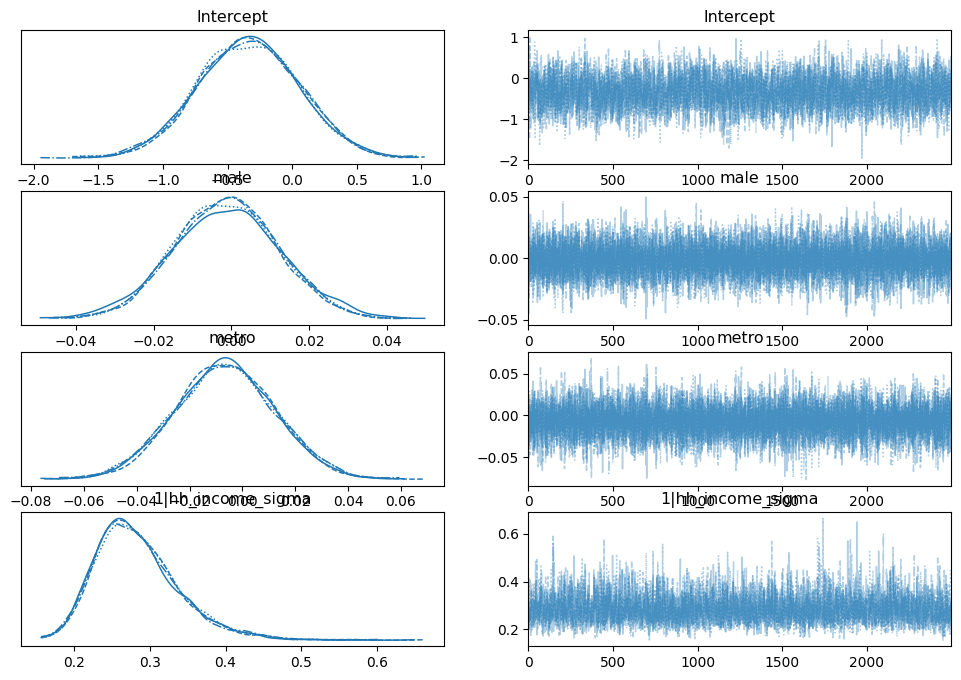

In [61]:
az.plot_trace(
    pr_debt_model_idata,
    var_names=["Intercept", "male", "metro", "1|hh_income_sigma"],
)

array([<Axes: title={'center': 'metro'}>,
       <Axes: title={'center': 'male'}>,
       <Axes: title={'center': 'citizen'}>], dtype=object)

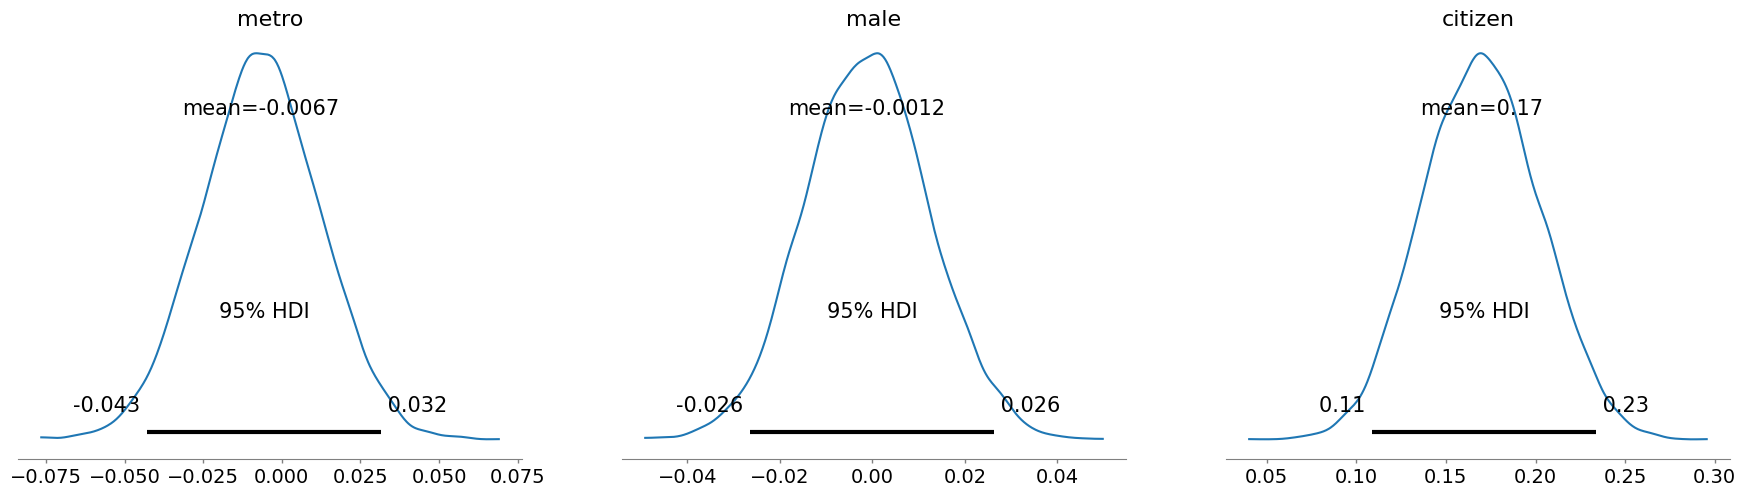

In [62]:
az.plot_posterior(
    pr_debt_model_idata,
    var_names=["metro", "male", "citizen"],
    hdi_prob=0.95
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

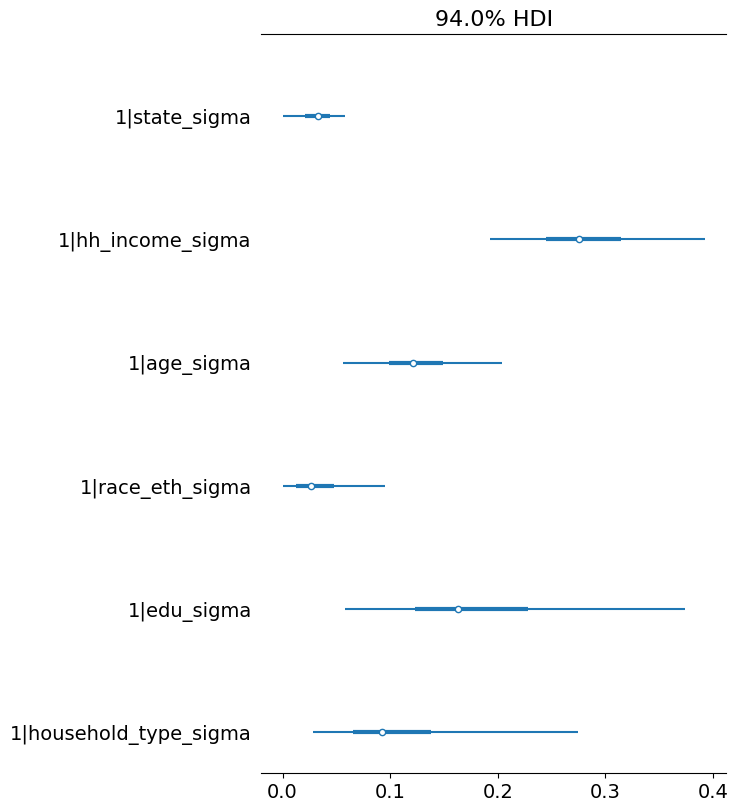

In [63]:
az.plot_forest(
    pr_debt_model_idata,
    var_names=["1|state_sigma",
               "1|hh_income_sigma",
               "1|age_sigma",
               "1|race_eth_sigma",
               "1|edu_sigma",
               "1|household_type_sigma"],
    combined=True,
)
